In [44]:
import gspread

# access granted via: https://console.developers.google.com/
# source file: https://docs.google.com/spreadsheets/d/1xyzvvtAw3Sb5qBHrm_IpT3ogfywgedrrtIQ7uCPkHUo/edit#gid=1683777169
spreadsheet_key = "1xyzvvtAw3Sb5qBHrm_IpT3ogfywgedrrtIQ7uCPkHUo" 


# open the google spreadsheet to load data
gc = gspread.service_account("./spreadsheet-access-276311-b2b7b45dd660.json")

book = gc.open_by_key(spreadsheet_key)
relationships_sheet = book.worksheet('Relationships')
people_sheet = book.worksheet('People')
companies_sheet = book.worksheet('Companies')


In [45]:
import pandas

# load each sheet into own dataframe
rel_df = pandas.DataFrame(relationships_sheet.get_all_records())
people_df = pandas.DataFrame(people_sheet.get_all_records())
companies_df = pandas.DataFrame(companies_sheet.get_all_records())

rel_df

,Name,Relationship,Company
0,Zhong Yuan Xu,founded,Deliverect
1,Jan Hollez,founded,Deliverect
2,Jelte Vrijhoef,founded,Deliverect
3,Jerome Laredo,founded,Deliverect
4,Zhong Yuan Xu,founded,POSIOS
...,...,...,...
147,,founded,
148,,founded,
149,,founded,
150,,founded,


In [46]:
# capture the names of people and companies and relationship types
# from the ones actually used in Relationships tab
# to avoid drawing a lot of unconnected nodes

people = list(people_df['Name'].unique())
rel_people = rel_df['Name'].unique()

companies = list(companies_df['Name'].unique())
rel_companies = list(rel_df['Company'].unique())

relationship = list(rel_df['Relationship'].unique())

print("\n")
print(len(rel_df), "relationships defined between")
print(len(rel_people), "unique source nodes (", len(people_df), "unique persons known)")
print(len(rel_companies), "unique target nodes (", len(companies_df), "unique companies known)")



152 relationships defined between
47 unique source nodes ( 273 unique persons known)
43 unique target nodes ( 115 unique companies known)


In [47]:
# sanity check: if any of the founders show up in our Companies dataset
# print their names to find data errors
for name in rel_df['Name']:
    if name in companies:
        print (name, "is a founder, not a company!")

In [48]:
# Visualization metadata prep

# some visualization constants
company_size = 50
person_size = 10
line_width = 0.2

# add a few graph drawing related metadata columns to dataframes
rel_df['size'] = [ company_size if name in companies else person_size for name in rel_df['Name'] ]
rel_df['width'] = [ (line_width*3) if relationship=='founded' else line_width for relationship in rel_df['Relationship'] ]


In [49]:
import networkx as nx

# draw the graph connecting founders with companies

# create graph
G = nx.from_pandas_edgelist(rel_df, source='Name', target='Company', edge_attr=True, create_using=nx.DiGraph)

# change the node sizes depending on their type
#
# expanded way of doing the same
# cosize_dict = { i : company_size for i in companies_df['Name'] }
# nx.set_node_attributes(G, cosize_dict, 'size')

nx.set_node_attributes(G, 1, 'size')    # default
nx.set_node_attributes(G, dict.fromkeys(people_df['Name'], person_size), 'size')  # people nodes
nx.set_node_attributes(G, dict.fromkeys(companies_df['Name'], company_size), 'size') # company nodes

print(G.nodes(data=True))


[('Zhong Yuan Xu', {'size': 10}), ('Deliverect', {'size': 50}), ('Jan Hollez', {'size': 10}), ('Jelte Vrijhoef', {'size': 10}), ('Jerome Laredo', {'size': 10}), ('POSIOS', {'size': 50}), ('Miki Kuusi', {'size': 10}), ('Wolt', {'size': 50}), ('Mika Matikainen', {'size': 10}), ('Lauri Andler', {'size': 10}), ('Oskari Pétas', {'size': 10}), ('Elias (Pietilä) Aalto', {'size': 10}), ('Juhani Mykkänen', {'size': 10}), ('Jonas Dhaenens', {'size': 10}), ('Team.blue', {'size': 50}), ('Pitchdrive', {'size': 50}), ('Marek Sacha', {'size': 10}), ('Rohlik', {'size': 50}), ('Benefio', {'size': 50}), ('Kim Fournais', {'size': 10}), ('Saxo Bank', {'size': 50}), ('Lars seier Christensen', {'size': 10}), ('Martin Kring', {'size': 10}), ('Relabee', {'size': 50}), ('Kring', {'size': 50}), ('Valified', {'size': 50}), ('Martin Villig', {'size': 10}), ('Bolt', {'size': 50}), ('Markus Villig', {'size': 10}), ('Skype', {'size': 50}), ('Garage48 Foundation', {'size': 50}), ('Slush', {'size': 50}), ('Avenla', {'

In [ ]:
# todo - extract some network stats



Wrote network_graph.png


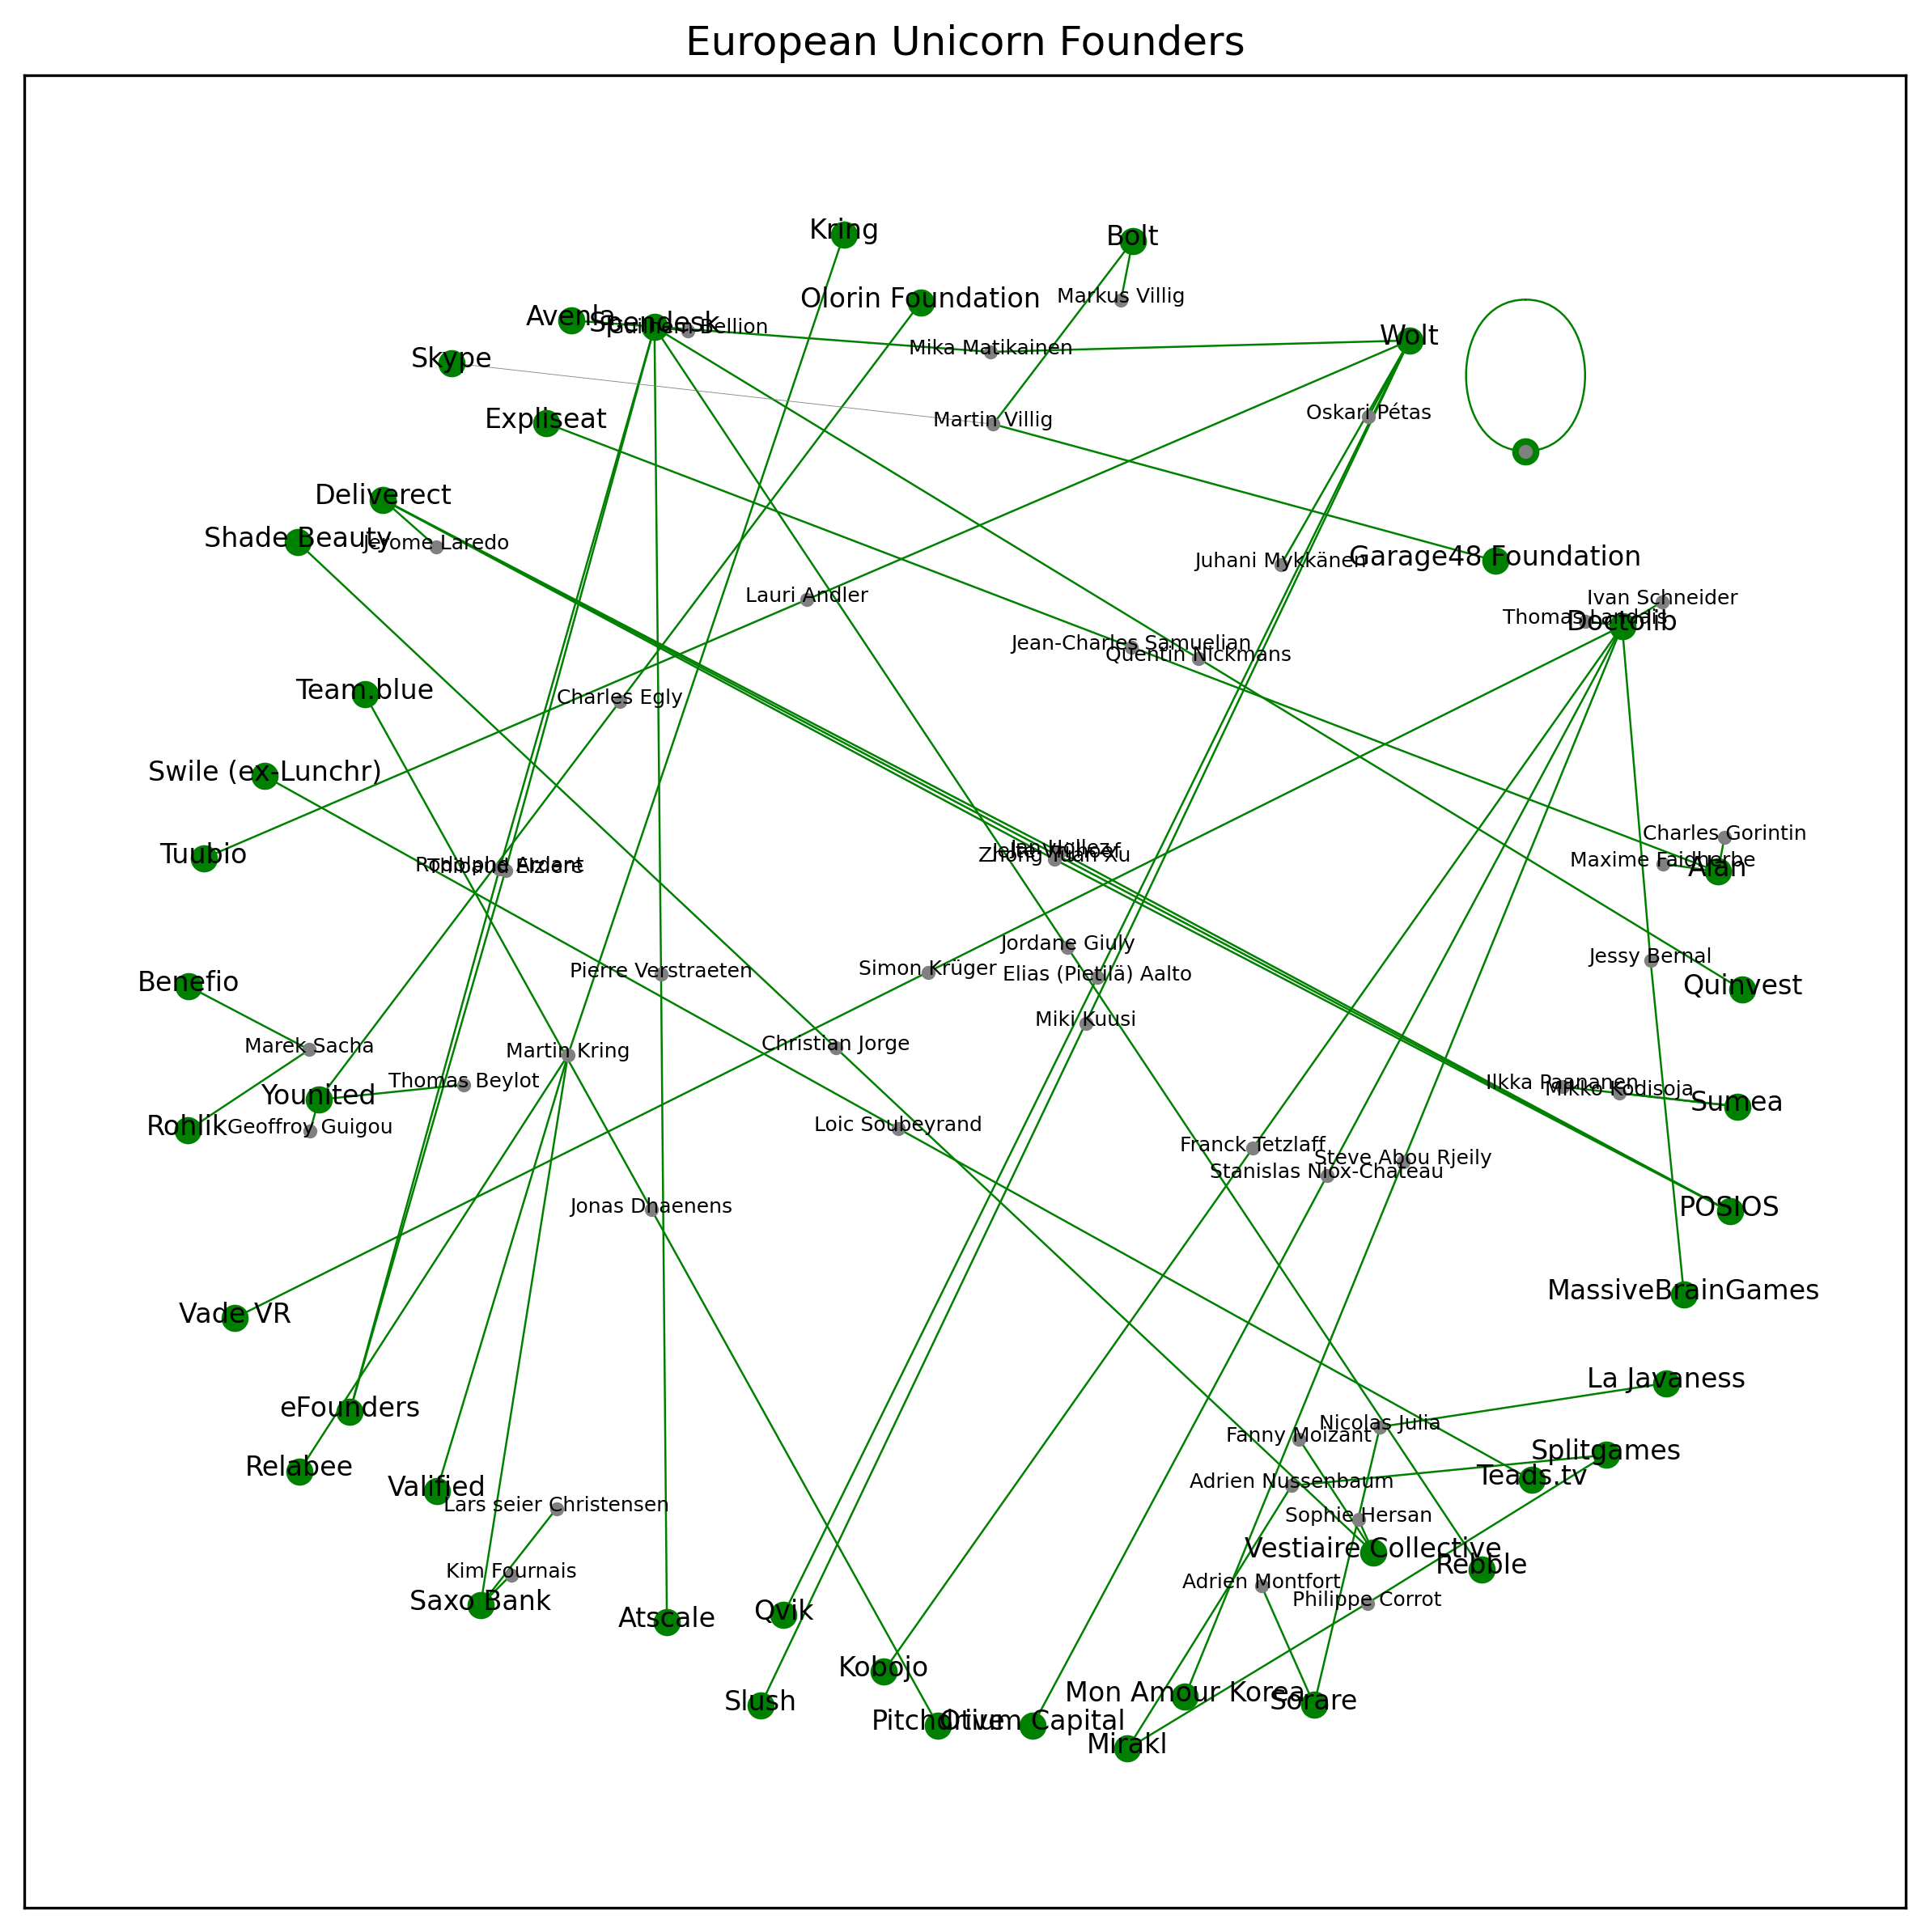

In [50]:
# Draw the static network image

import matplotlib
import matplotlib.pyplot as plt

# clean canvas
plt.figure(3,figsize=(10,10), dpi=300) 

# layout = nx.spring_layout(G, iterations=150)
layout = nx.fruchterman_reingold_layout(G, iterations=50, scale=5)


# draw company nodes
nx.draw_networkx_nodes(G, 
                       layout, 
                       nodelist=rel_companies, 
                       node_size=company_size,
                       node_color='green')


# print(G.nodes(data=True))

# calculate the node label positions to be off center
pos_higher = {}
y_off = 0.02  # offset on the y axis

for k, v in layout.items():
    pos_higher[k] = (v[0], v[1]+y_off)

company_labels = dict(zip(rel_companies, rel_companies))
nx.draw_networkx_labels(G, pos_higher, labels=company_labels, font_size=8)

# draw people nodess
nx.draw_networkx_nodes(G, 
                       layout, 
                       nodelist=rel_people,
                       node_size=person_size, 
                       node_color='grey')

person_labels = dict(zip(rel_people, rel_people))
nx.draw_networkx_labels(G, pos_higher, labels=person_labels, font_size=6)

# separate sets of edges by relationship type
founder_edges = list((u,v) for u,v,d in G.edges(data=True) if d['Relationship']=='founded')
employee_edges = list((u,v) for u,v,d in G.edges(data=True) if d['Relationship']=='worked at')
investor_edges = list((u,v) for u,v,d in G.edges(data=True) if d['Relationship']=='invested in')

nx.draw_networkx_edges(G,
                        layout,
                        width=line_width*3,
                        arrows=False,
                        edgelist=founder_edges,
                        edge_color="green")

nx.draw_networkx_edges(G,
                        layout,
                        width=line_width,
                        arrows=False,
                        edgelist=investor_edges,
                        edge_color="blue")

nx.draw_networkx_edges(G,
                        layout,
                        width=line_width,
                        arrows=False,
                        edgelist=employee_edges,
                        edge_color="grey")

plt.title("European Unicorn Founders")
#plt.axis('off')

plt.savefig("network_graph.png",dpi=300)
print("Wrote network_graph.png")
